In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tessa
from tessa.app import TessaCore
from pathlib import Path


import tessa.building_data as bd

In [32]:
app = TessaCore.launch_instance()
engine = app.database.engine
base_path = Path(app.file_storage.directory)
test_data_path = base_path / 'load_curves' / "test_data"
base_path = Path(app.file_storage.directory,'..')
path_file = os.path.abspath(base_path / 'geneap'/'thermal_system_models' / 'data'/ "dhn_hourly_heat_lost_fractions.csv")

[GENEAPApplication] WARNING | Unrecognized alias: 'f', it will have no effect.


In [33]:
geoimpact_data = pd.read_csv(test_data_path / "2_regbl2021_building_sample.csv", sep=",")
set_up_geoimpact = bd.setup_building_index(geoimpact_data)
list_buildings_geoimpact = bd.extract_egid_list_from_table(set_up_geoimpact)
data_table = bd.request_regbl_2021_data(list_buildings_geoimpact, engine)
building_set = tessa.app.models.District.from_ids(list_buildings_geoimpact,
                                               building_data_source=app.building_data_source, 
                                               climate_data_source=app.climate_data_source, 
                                               heat_model=app.heat_model)

In [34]:
from pathlib import Path
from importlib import resources

import pandas as pd

def calculate_annual_heat_loss_percentage(linear_heat_density):
    """
    Give the annual heat loss of the district heating in percentage per year.
    Based on Thomas Nussbaumer & Stefan Thalmann report [1]


    Parameters
    ----------
    linear_heat_density : kWh/m

    Returns
    -------
    float:
            Estimated annual heat loss in % / year

    References
    ----------
    [1] Status Report on District Heating Systems in IEA Countries IEA Bioenergy Task 32,
    Swiss Federal Office of Energy, and Verenum, Zürich 2014 ISBN 3-908705-28-2
    """
    annual_heat_loss_percentage = 17 * np.power(linear_heat_density, -0.5) / 100
    return annual_heat_loss_percentage


def load_hourly_heat_loss_percentage():
    """
        Load the hourly heat loss percentage based
        on return of experience of the CADSIG-CADIOM connexion [2]

        Returns
        -------
        Series:
                With 8760 float values
                hourly percentage of heat losses on the district heating

        References
        ----------
        [2] QUIQUEREZ, Loic, FAESSLER, Jérôme, LACHAL, Bernard Marie & Services Industriels de Genève.
        Réseaux thermiques multi-ressources efficients et renouvelables: Etude de cas
        de la connexion des réseaux thermiques CADIOM (chaleur fatale) et CADSIG (gaz)
        à Genève et perspectives d’évolution. Genève : Services Industriels de Genève, 2015
    """
    
    heat_loss_percent = pd.read_csv(path_file, sep=",")
    
    return heat_loss_percent['pertes_pourcent'] / 100 


def load_monthly_heat_loss_percentage():
    """
        Load the monthly heat loss percentage based
        on return of experience of the CADSIG-CADIOM connexion [2]


        Returns
        -------
        Series:
                With 12 float values
                monthly percentage of heat losses on the district heating

        References
        ----------
        [2] QUIQUEREZ, Loic, FAESSLER, Jérôme, LACHAL, Bernard Marie & Services Industriels de Genève.
        Réseaux thermiques multi-ressources efficients et renouvelables: Etude de cas
        de la connexion des réseaux thermiques CADIOM (chaleur fatale) et CADSIG (gaz)
        à Genève et perspectives d’évolution. Genève : Services Industriels de Genève, 2015
    """
    from ..thermal_system_models import data as thermal_data
    source = resources.files(thermal_data).joinpath("dhn_monthly_heat_lost_percentage.csv")
    with resources.as_file(source) as parameter_file:
        with Path(parameter_file).open() as f:
            return pd.read_csv(f, sep=",").set_index('heure')['pertes_pourcent'] / 100
    # return pd.read_csv(Path(base_path) / 'load_curves' / 'heat_parameters' / 'dhn_monthly_heat_lost_percentage.csv',
    #                    sep=",").set_index('month')['pertes_pourcent']


def calculate_network_heat_loss(heat_loss_percent, annual_heat_loss_percentage):
    """
    Give the hourly fraction of the heat loss.
    Based on return of experience of the CADSIG-CADIOM connexion [2]

    Parameters
    ----------
    base_path :                   Path of folder containing data parameters

    annual_heat_loss_percentage : Output of annual_heat_loss function

    Returns
    -------
    Series:
            With 8760 float values
            These are the hourly percentage of heat losses on the district heating

    References
    ----------
    [2] QUIQUEREZ, Loic, FAESSLER, Jérôme, LACHAL, Bernard Marie & Services Industriels de Genève.
    Réseaux thermiques multi-ressources efficients et renouvelables: Etude de cas
    de la connexion des réseaux thermiques CADIOM (chaleur fatale) et CADSIG (gaz)
    à Genève et perspectives d’évolution. Genève : Services Industriels de Genève, 2015
    """
    return heat_loss_percent * annual_heat_loss_percentage


def calculate_hourly_network_production (hourly_heat_loss_percentage, hourly_load_curve):
    '''
    Give the hourly heat loss of the district heating.
    Based on return of experience of the CADSIG-CADIOM connexion [2]  
    
    Parameters
    ----------
    hourly_heat_loss : Output of hourly_heat_loss_percentage function
    
    building_set :     Output of building_set.load_curve
                          
    Returns
    -------
    Series:
            With 8760 float values
            These are the hourly heat losses on the district heating
    '''
    hourly_network_production = pd.DataFrame()
    list_a = hourly_load_curve['p_hww_kw']
    list_b = hourly_heat_loss_percentage
    hourly_network_production['p_hww_kw_lost'] = [a*b for a,b in zip(list_a, list_b)]
    list_c = hourly_network_production['p_hww_kw_lost']
    hourly_network_production['p_hww_kw_with_lost'] = [a+b for a,b in zip(list_a, list_c)]
    rng = pd.date_range('2015-01-01', periods=8760, freq='H')
    hourly_network_production = pd.DataFrame({'date': rng, 'p_hww_kw_production': hourly_network_production['p_hww_kw_with_lost'] })
    return hourly_network_production

In [35]:
building_set.buildings
building_set.calc_load_curves()
hourly_load_curve = building_set.load_curve
annual_heat_loss_percentage = calculate_annual_heat_loss_percentage (3)
heat_loss_percent = load_hourly_heat_loss_percentage()
hourly_heat_loss_percentage = calculate_network_heat_loss (heat_loss_percent, annual_heat_loss_percentage)
hourly_network_production = calculate_hourly_network_production (hourly_heat_loss_percentage, hourly_load_curve)

In [36]:
hourly_network_production

date  p_hww_kw_production
0    2015-01-01 00:00:00          208.040196
1    2015-01-01 01:00:00          211.787377
2    2015-01-01 02:00:00          232.233412
3    2015-01-01 03:00:00          235.542906
4    2015-01-01 04:00:00          239.711527
...                  ...                 ...
8755 2015-12-31 19:00:00          136.062644
8756 2015-12-31 20:00:00          147.927189
8757 2015-12-31 21:00:00          157.766991
8758 2015-12-31 22:00:00          177.359724
8759 2015-12-31 23:00:00          165.834199

[8760 rows x 2 columns]

In [37]:
# Température de la ressource > Tcad aller (80°C)
def calc_power_high_geothermal (t_ressource, flow_ressource):
    """
    Give the theoretical power in kW of the geothermal resource. 
    This is the geothermal valorization made in direct, that is to say that the temperature of the resource is higher than 80° (T°C go of the CAD). 
    This valorization is made until the return temperature of the CAD (60°)
    The flow ressource is in l/s and t_ressource is in °C
    """
    t_return = 60
    power = (t_ressource - t_return) * flow_ressource * 4.18
    return power 

# Température de la ressource > Tcad aller (80°C)
def calc_flow_high_geothermal (t_ressource, power):
    """
    Give the flow ressource in l/s needed to have the wanted power
    """
    t_return = 60
    flow_ressource = power / ((t_ressource - t_return) * 4.18)
    return flow_ressource

def calc_ressource_1_high_geothermal (t_ressource, flow_ressource):
    """
    """    
    power = calc_power_high_geothermal (t_ressource, flow_ressource)
    hourly_network_production['power_direct_geothermal'] = power
    hourly_network_production['other_power'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['power_direct_geothermal']
    hourly_network_production['other_power'] = np.where(hourly_network_production['other_power']<0,0,hourly_network_production['other_power'])
    hourly_network_production['power_direct_geothermal'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['other_power']
    total_energy = hourly_network_production['p_hww_kw_production'].sum()
    total_energy_non_ren = hourly_network_production['other_power'].sum()
    total_energy_ren = total_energy - hourly_network_production['other_power'].sum()
    perc_energy_ren = round((total_energy_ren / total_energy * 100),2)
    
    #return hourly_network_production, print("The percentage of the renewable production is: " + str(perc_energy_ren) + "%")
    return hourly_network_production

def calc_power_geothermal_with_heat_pump (t_ressource, flow_ressource):
    """
    Give the theoretical power in kW of the geothermal resource. 
    This is the geothermal valorization made with an heat pump, that is to say that the temperature of the resource is lower than 80° (T°C go of the CAD). 
    The flow ressource is in l/s and t_ressource is in °C
    """
    t_going_cad = 80
    t_geo_reinj_min = 25
    cop_fix = 4
    
    q_evap = (t_ressource - t_geo_reinj_min) * flow_ressource * 4.18
    cop = (0.45 * (t_going_cad + 273)) / ((t_going_cad + 273) - (t_ressource + 273))

    q_cond = cop_fix * q_evap / (cop_fix - 1)
    q_elec = q_cond - q_evap
    
    return q_cond

def calc_ressource_2_geothermal_with_heat_pump (t_ressource, flow_ressource):
    """
    """ 
    power = calc_power_geothermal_with_heat_pump (t_ressource, flow_ressource)
    hourly_network_production['power_geothermal_with_heat_pump'] = power
    hourly_network_production['other_power'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['power_geothermal_with_heat_pump']
    hourly_network_production['other_power'] = np.where(hourly_network_production['other_power']<0,0,hourly_network_production['other_power'])
    hourly_network_production['power_geothermal_with_heat_pump'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['other_power']
    total_energy = hourly_network_production['p_hww_kw_production'].sum()
    total_energy_non_ren = hourly_network_production['other_power'].sum()
    total_energy_ren = total_energy - hourly_network_production['other_power'].sum()
    
    perc_energy_ren = round((total_energy_ren / total_energy * 100),2)

    #return hourly_network_production, print("The percentage of the renewable production is: " + str(perc_energy_ren) + "%")
    return hourly_network_production

def calc_power_heat_pump_water (t_ressource):
    """
    """
    t_going_cad = 80
    cop = (0.45 * (t_going_cad + 273)) / ((t_going_cad + 273) - (t_ressource + 273))
    q_cond = cop * q_evap / (cop - 1)
    q_elec = q_cond - q_evap
    
    return q_cond    

def calc_share_gas (power):
    """
    """
    gas_efficiency = 0.916
    hourly_network_production['power_gas'] = power * gas_efficiency
    hourly_network_production['other_power'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['power_gas']
    hourly_network_production['other_power'] = np.where(hourly_network_production['other_power']<0,0,hourly_network_production['other_power'])
    hourly_network_production['power_gas'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['other_power']
    total_energy = hourly_network_production['p_hww_kw_production'].sum()
    total_energy_other = hourly_network_production['other_power'].sum()
    total_energy_gas = total_energy - hourly_network_production['other_power'].sum()
    
    perc_energy_gas = round((total_energy_gas / total_energy * 100),2)
    return hourly_network_production  

def calc_share_wood (power):
    """
    """
    wood_efficiency = 0.622
    hourly_network_production['power_wood'] = power * wood_efficiency
    hourly_network_production['other_power'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['power_wood']
    hourly_network_production['other_power'] = np.where(hourly_network_production['other_power']<0,0,hourly_network_production['other_power'])
    hourly_network_production['power_wood'] = hourly_network_production['p_hww_kw_production'] - hourly_network_production['other_power']
    total_energy = hourly_network_production['p_hww_kw_production'].sum()
    total_energy_other = hourly_network_production['other_power'].sum()
    total_energy_wood = total_energy - hourly_network_production['other_power'].sum()
    
    perc_energy_wood = round((total_energy_wood / total_energy * 100),2)
    return hourly_network_production 

In [38]:
import ipywidgets as widgets

In [39]:
n_resources = 5

options = []
power_inputs = []

for i in range(n_resources):
    d = widgets.Dropdown(
        options=['Géothermie HT (directe)', 'Géothermie MT (avec PAC)', 'PAC sur eau', 'Bois', 'Gaz', 'Aucune'],
        description=f'Ressource {i +1}:',
        value='Aucune',
        disabled=False
    )

    p = widgets.FloatText(
            value=0,
            description='Power [kW]:',
            disabled=False
        )
    
    power_inputs.append(p)
    w = widgets.HBox([d, p])
    options.append(w)
    
update_button = widgets.Button(description='Mise à jour du calcul')  

class ResourceEdit:
    
    results = None
    
    def _on_update_calc(self, event):
        self.results = []
        for o in options:
            t =  o.children[0].value
            p = o.children[1].value
            
            self.results.append( (t, p) )

In [40]:
r = ResourceEdit()
update_button.on_click(r._on_update_calc)
v = widgets.VBox(options + [update_button])

In [41]:
v

In [42]:
building_set.buildings
building_set.calc_load_curves()
hourly_load_curve = building_set.load_curve
annual_heat_loss_percentage = calculate_annual_heat_loss_percentage (3)
heat_loss_percent = load_hourly_heat_loss_percentage()
hourly_heat_loss_percentage = calculate_network_heat_loss (heat_loss_percent, annual_heat_loss_percentage)
hourly_network_production = calculate_hourly_network_production (hourly_heat_loss_percentage, hourly_load_curve)

In [43]:
power_sources = r.results
power_sources = [(name, power) for name, power in power_sources if power != 0]

In [44]:
def ressources_for_monotone(power_sources, hourly_network_production):
    hourly_network_production['power_remain'] = hourly_network_production['p_hww_kw_production']
    for name, power in power_sources:
        if power != 0:
            hourly_network_production['power'] = power
            hourly_network_production[f'power_{name}_used'] = hourly_network_production[['power_remain', 'power']].min(axis=1)
            hourly_network_production['power_remain'] = hourly_network_production['power_remain'] - hourly_network_production[f'power_{name}_used']
        
    hourly_network_production =  hourly_network_production.drop('power', axis=1)

    return hourly_network_production

In [45]:
table_ressources = ressources_for_monotone (power_sources, hourly_network_production)

In [46]:
def table_monotone_from_resources(table_ressources, power_sources):
    columns = [f'power_{name}_used' for name, power in power_sources]
    table_ressources = table_ressources[columns + ['p_hww_kw_production', 'power_remain']].copy()
    
    table_ressources['cumulative_ressources'] = table_ressources[columns].sum(axis=1)
    
    table_monotone = pd.DataFrame(columns=table_ressources.columns)
    for c in table_ressources.columns:
        table_monotone.loc[:, c] = table_ressources.loc[:, c].sort_values(ascending=False, ignore_index=True)
    
    return table_monotone

In [47]:
monotone_ressources = table_monotone_from_resources(table_ressources, power_sources)

In [48]:
def percentage_provided_ressource (monotone_ressources, power_sources):
    total_columns = monotone_ressources.apply(np.sum, axis=0).to_frame(name="total")
    total = monotone_ressources['p_hww_kw_production'].sum()
    total_columns['percentage'] = total_columns['total'].div(total) * 100
    columns = [f'power_{name}_used' for name, power in power_sources]
    list_percentage = total_columns['percentage'].values.tolist()
    df = pd.DataFrame (columns, columns = ['ressource'])
    df2 = pd.DataFrame (list_percentage, columns = ['percentage'])
    final_table = result = pd.concat([df, df2], axis=1).dropna()
    
    return final_table

In [49]:
percentage_ressources = percentage_provided_ressource (monotone_ressources, power_sources)

In [50]:
def normalised_ressource (table_ressources):
    for col in table_ressources.columns.drop(['date','p_hww_kw_production']):
        table_ressources[f'normalised_{col}_used'] = table_ressources[col] / table_ressources['p_hww_kw_production'] * 100
    return table_ressources

In [51]:
normalised_ressources = normalised_ressource (table_ressources)

In [71]:
red_line = widgets.Output(layout={'border': '2px solid red'})
for index, row in percentage_ressources.iterrows():
    red_line.append_stdout(f"With the : { row['ressource']} : {int(row['percentage'])} % of the annual heat demand is provided \n")
red_line

Output(layout=Layout(border='2px solid red'), outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'Wi…

In [55]:
def plot_monotone_charge_cumul(monotone_ressources, power_sources):
       
    columns = [f'power_{name}_used' for name, power in power_sources]
    monotone_ressources[columns + ['power_remain']].plot.area(figsize=(15,10))
    
    plt.title("Load monotone of the different means of production chosen \n",fontsize=20)
    plt.xlabel("Hours", fontsize=15)
    plt.ylabel("Power [kW]", fontsize=15)
    plt.legend()   

In [63]:
def plot_camembert_percentage(percentage_ressources):
    plt.figure(figsize=(14,7))

    ax1 = plt.subplot(121, aspect='equal')
    ax1.set_title('Distribution of the annual heat demand met for the selected resources and power', fontsize=15)

    percentage_ressources.plot(kind='pie', y = 'percentage', ax=ax1, autopct='%1.1f%%', 
    startangle=90, shadow=False, labels=percentage_ressources['ressource'], legend = False, fontsize=11)
    plt.ylabel("")

In [57]:
def plot_normalised_ressource(normalised_ressources):
       
    normalised_cols = [col for col in normalised_ressources.columns if 'normalised' in col]
    normalised_ressources[normalised_cols].plot.area(figsize=(15,10))
    
    plt.title("Standardized hourly distribution of selected resources \n",fontsize=20)
    plt.xlabel("Hours", fontsize=15)
    plt.ylabel("Heat demand [%]", fontsize=15)
    plt.legend() 

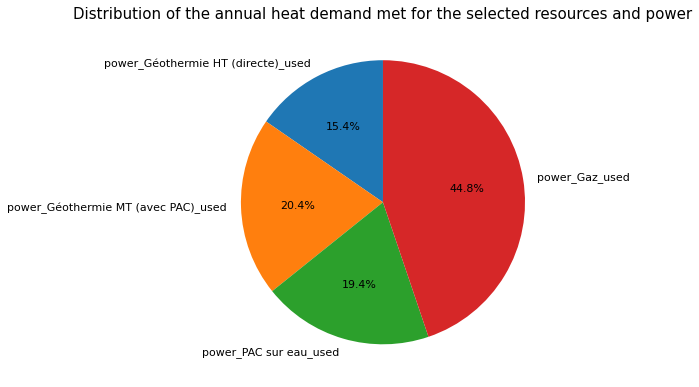

In [64]:
plot_camembert_percentage(percentage_ressources)

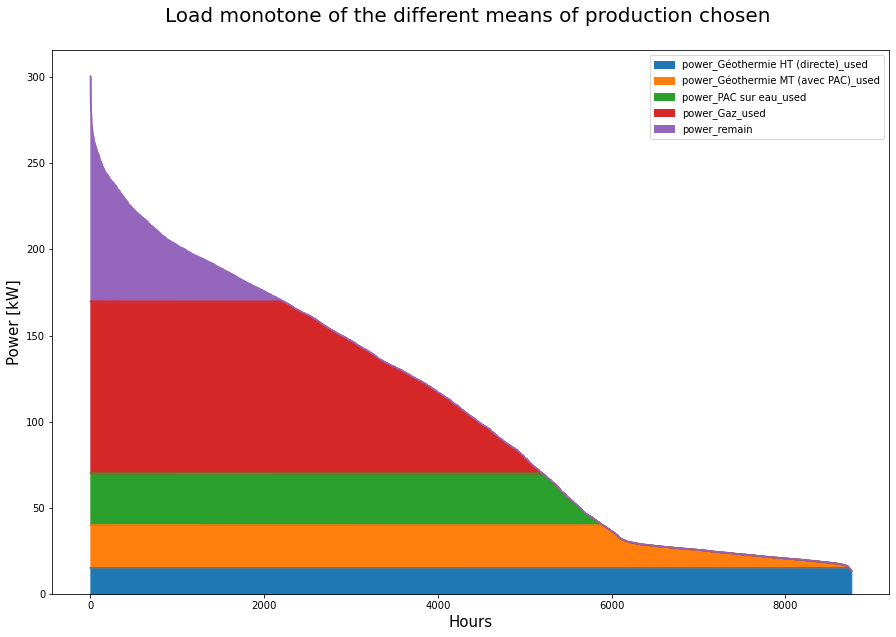

In [59]:
plot_monotone_charge_cumul (monotone_ressources, power_sources)

In [ ]:
plot_normalised_ressource(normalised_ressources)